<a href="https://colab.research.google.com/github/JayThibs/Credit_Card_Fraud_Detection/blob/master/Credit_Card_Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

TO DO


*   Create new visualization in exploration
*   Try out different models and test sizes
*   Use all visualizations to test model (cost function, etc.)
*   Make sure the data always outputs the same thing.


# Introduction

---

We will be build a credit card fraud detection model. The goals of this notebook are the following:



*   Show how to create a fraud detection system
*   Explain how to deal with imbalanced datasets
*   Use a wide variety of models to get a better understanding of which ones work better
*   Use Semi-Supervised Classification

---


Table of Contents

I. Understanding Our Data
1. Gather Sense of our Data

II. Preprocessing
1. Scaling and Distributing
2. Splitting the Data

III. Random Undersampling and Oversampling
1. Distributing and Correlation
2. Anomaly Detection
3. Dimensionality Reduction and Clustering (t-SNE)
4. Classifiers
5. A Deeper Look into Logistic Regression
6. Oversampling with SMOTE

IV. Testing
1. Testing with Logistic Regression
2. Neural Networks Testing (Undersamping vs Oversamping)

# Problem Statement:

Credit card fraud is a problem where some of the credit card transactions turn out to be fraud. Credit card companies would like to reduce the risks of fraud in order to reduce the costs associated. Our model's aim is to try to eliminate fraudulent transactions.

# Importing Libraries

In [0]:
# Import Libraries

import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
sns.set(style="whitegrid")
import random
import tensorflow as tf
from sklearn.preprocessing import scale
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.utils import shuffle
from pylab import rcParams
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]
import plotly
import time

# Classifier Libraries 
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

import collections

# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.filterwarnings("ignore")

# Data Exploration

Let's load the data and check it out.

In [18]:
df = pd.read_csv('/content/creditcard 2.csv', low_memory=False) # import file
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


The features are already scaled and the names of features are not shown due to privacy reasons.

Now, let's have a look at how many of the transactions are fraudulent.

In [19]:
# loc locates all data by column or conditional statement
frauds = df.loc[df['Class'] == 1] # find all rows that are fraudulent
non_frauds = df.loc[df['Class'] == 0] # final all rows that aren't fraudulent
print('Frauds ', len(frauds), ' transactions or ', round(df['Class'].value_counts()[0]/len(df)*100, 2), '% of the dataset')
print('No Fraud ', len(non_frauds), ' transactions or ', round(df['Class'].value_counts()[1]/len(df)*100, 2), '% of the dataset')

Frauds  492  transactions or  99.83 % of the dataset
No Fraud  284315  transactions or  0.17 % of the dataset


Only 492 of the transactions are fraudulent. This means that the dataset is quite imbalanced; 99.83% of transactions are normal. The cases of fraud are anomalies and therefore our model will be doing anomaly detection to find out which transactions are fraudulent.

We do not want to use this dataframe as the base for our predictive models and analysis because we will get a lot of errors and our model will overfit since it will assume that most transactions are not fraud. This will require us to modify the dataframe quite a bit later on so that we can create a model that will properly predict (patterns of) fraud.

Let's have a look at some of the statistics regarding the dataset.

In [20]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


Let's have a look if there are any Null values:

In [21]:
df.isnull().sum().max()

0

Perfect, no Null values!

## Let's Visualize the data

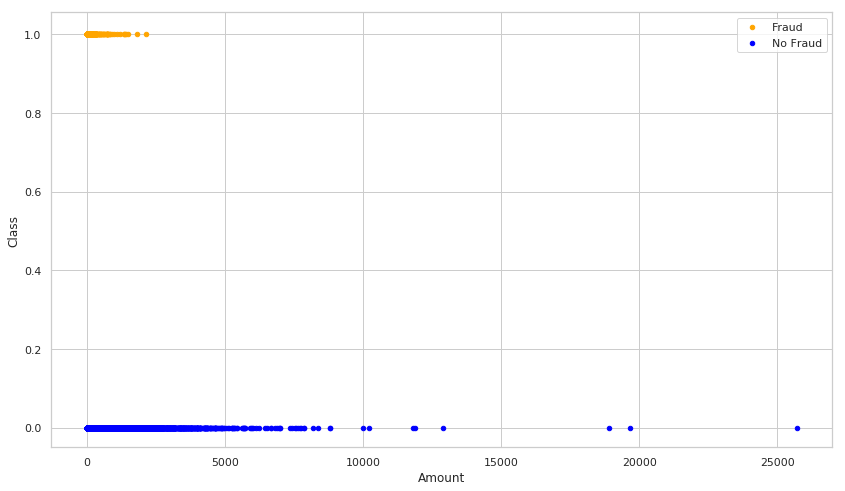

In [22]:
ax = frauds.plot.scatter(x='Amount', y='Class', color='Orange', label='Fraud')
non_frauds.plot.scatter(x='Amount', y='Class', color='Blue', label='No Fraud', ax=ax)
plt.show()

### Let's also Visualize with Seaborn

Text(0.5, 1.0, 'Class Distributions \n (0: No Fraud || 1: Fraud)')

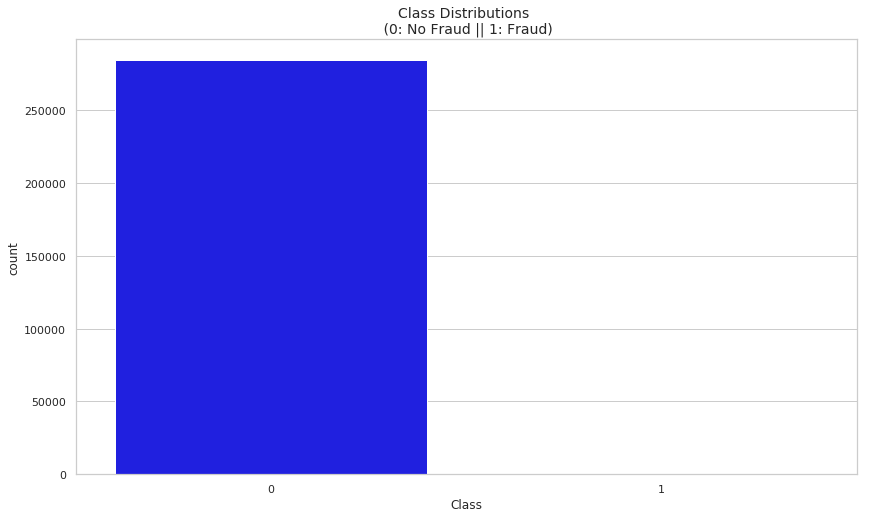

In [23]:
colors = ['Blue', 'Orange']

sns.countplot('Class', data=df, palette=colors)
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=14)

Yup... Definitely skewed.

Let's have a look at the distributions:

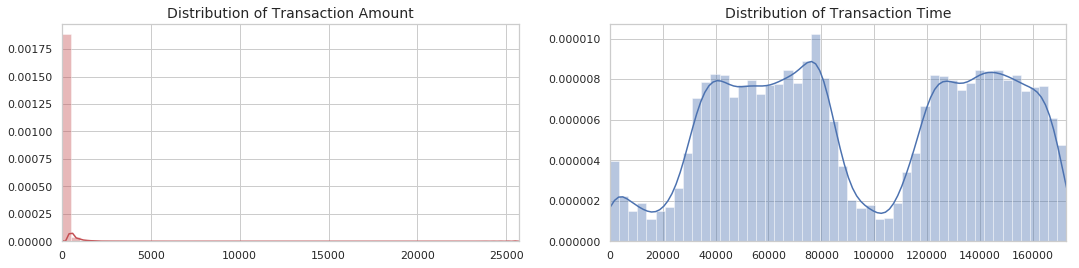

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

amount_val = df['Amount'].values
time_val = df['Time'].values

sns.distplot(amount_val, ax=ax[0], color='r')
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.distplot(time_val, ax=ax[1], color='b')
ax[1].set_title('Distribution of Transaction Time', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])

plt.show()

# Scaling and Distribution

**Scaling**: We will be scaling the columns **Time** and **Amount**.

**Distributing**: We will create a subsample of the dataframe in order to have an equal amount of Fraud and Non-Fraud cases. This will help our algorithm better understand patterns that determines whether a transaction is a fraud or not.

The subsample will be a dataframe with a 50/50 ratio of fraud and non-fraud transactions. This is important to avoid overfitting and give us the correct correlations between the features.

We need to randomly choose 492 cases from the non-fraud transactions and placed them in our new dataframe.

Most of our data is already scaled, so we only need to scale the **Time** and **Amount** features:

In [0]:
from sklearn.preprocessing import StandardScaler, RobustScaler

# RobustScaler is less prone to outliers.

std_scaler = StandardScaler()
rob_scaler = RobustScaler()

df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Time','Amount'], axis=1, inplace=True) # removing non-scaled time and
# amount from the dataframe

In [26]:
scaled_amount = df['scaled_amount']
scaled_time = df['scaled_time']

df.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True) # remove from end
df.insert(0, 'scaled_amount', scaled_amount) # place scaled amount at column 1
df.insert(1, 'scaled_time', scaled_time) # place scaled time at column 2

# Amount and Time are now scaled!

df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


## Splitting the Data

Before we do **Random Undersampling**, we have to create our testing set from the original dataframe so that we can test our model created from the undersampled dataframe on the original dataframe's test set.

In [27]:
print('No Frauds', round(df['Class'].value_counts()[0]/len(df)*100, 2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df)*100, 2), '% of the dataset')

X = df.drop('Class', axis=1)
y = df['Class']

skf = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in skf.split(X, y):
  print("Train:", train_index, "Test:", test_index)
  original_X_train, original_X_test = X.iloc[train_index], X.iloc[test_index]
  original_y_train, original_y_test = y.iloc[train_index], y.iloc[test_index]

# Turn into an array
original_X_train = original_X_train.values
original_X_test = original_X_test.values
original_y_train = original_y_train.values
original_y_test = original_y_test.values

# See if both the train and test label distribution are similarly distributed
train_unique_label, train_counts_label = np.unique(original_y_train, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_y_test, return_counts=True)
print('-' * 100)

print('Label Distributions: \n')
print(train_counts_label/ len(original_y_train))
print(test_counts_label/ len(original_y_test))

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset
Train: [ 30473  30496  31002 ... 284804 284805 284806] Test: [    0     1     2 ... 57017 57018 57019]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 30473  30496  31002 ... 113964 113965 113966]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 81609  82400  83053 ... 170946 170947 170948]
Train: [     0      1      2 ... 284804 284805 284806] Test: [150654 150660 150661 ... 227866 227867 227868]
Train: [     0      1      2 ... 227866 227867 227868] Test: [212516 212644 213092 ... 284804 284805 284806]
----------------------------------------------------------------------------------------------------
Label Distributions: 

[0.99827076 0.00172924]
[0.99827952 0.00172048]


# Random Undersample and Oversampling

Let's balance our dataset by using random undersampling!

Steps:

1. Determine how imbalanced our class is. **value_count()** applied to **Class** works well for this. In our case, this is 492.
2. Bring the number of non-fraud transactions to the same as fraud transactions.
3. *Shuffle the data** to see if our model can maintain a certain accuracy everytime we run our script.

Obviously, there is an issue with this method: because we are removing so many transactions, our dataset decreases in size significantly and there is information loss.

Let's shuffle the data before creating subsamples:

In [28]:
df = df.sample(frac=1)

# amount of fraud classes
fraud_df = df.loc[df['Class'] == 1]
non_fraud_df = df.loc[df['Class'] == 0][:492]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
65690,1.089918,-0.387563,0.885431,-0.958435,1.690805,1.235272,-1.698976,0.596398,-1.127428,0.467213,2.005677,-0.536369,-1.134214,0.113715,-1.858805,-0.735439,-1.133930,-0.790884,0.918716,-0.789864,-0.045559,-0.088574,-0.035708,0.143670,-0.041321,0.445595,0.172966,0.578637,0.034163,0.037930,0
221018,4.164186,0.677898,-3.367770,0.099249,-6.148487,3.401955,0.458307,-1.571630,-1.358708,0.672409,-3.188001,-4.937427,3.723933,-4.603176,1.019180,-6.619090,-0.590224,-4.472548,-7.165044,-1.581128,1.930380,0.264699,0.861308,1.249301,1.850627,-0.117471,1.219815,0.000251,1.036011,0.004367,1
127104,-0.122406,-0.076129,-1.124714,0.506002,1.097786,-2.700827,0.236686,0.302913,0.096488,0.588034,-1.897352,-0.569801,0.109893,0.719109,1.338130,0.140387,-0.698012,-0.378124,-0.966191,1.214368,-1.906322,-0.601745,-0.372828,-0.853611,-0.275113,-1.133917,0.401642,0.544785,-0.161793,-0.046541,0
102782,-0.033676,-0.191908,1.232604,-0.548931,1.087873,0.894082,-1.433055,-0.356797,-0.717492,0.003167,-0.100397,0.543187,-1.039417,0.285262,-0.206007,-0.498522,-1.064108,-2.156037,0.564761,0.837857,-0.728990,-0.576274,-0.448671,-0.517568,0.012833,0.699217,0.527258,-0.322607,0.080805,0.035427,1
226814,9.020471,0.706258,-2.405207,2.943823,-7.616654,3.533374,-5.417494,-0.112632,-1.329372,1.709417,-2.322716,-6.540989,4.404578,-4.938159,-0.740985,-7.462961,0.534968,-4.671032,-4.472403,-0.982090,3.490069,-0.338707,0.652683,0.414132,0.023869,-0.260616,0.405316,0.029107,0.519807,-0.469537,1


## Equally Distributing and Correlating:

Distribution of the Classes in the subsample dataset
1    0.5
0    0.5
Name: Class, dtype: float64


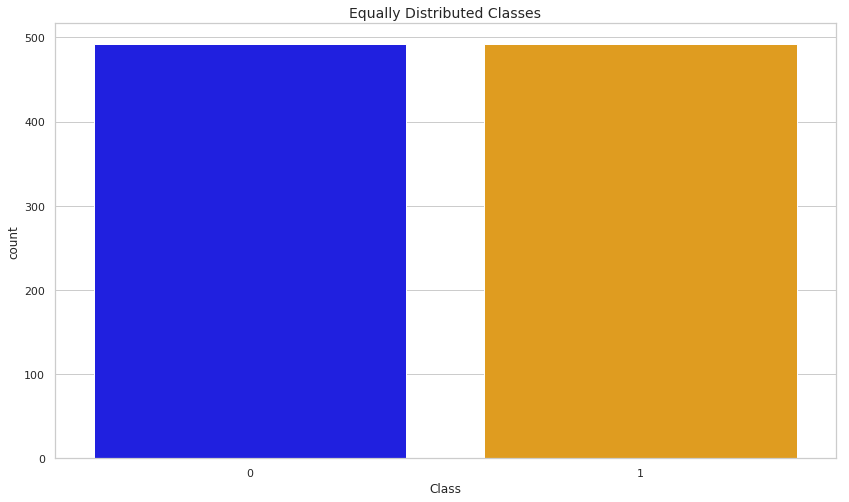

In [29]:
print('Distribution of the Classes in the subsample dataset')
print(new_df['Class'].value_counts()/len(new_df)) # percentage for each class

sns.countplot('Class', data=new_df, palette=colors)
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()

Perfect, we have a 50/50 split!

### Correlation Matrices

If we want to understand our data, correlation matrices can help us tremendously. This will help us learn which features heavily influence whether a specific transaction is a fraud. We are only using a correlation matrices now, after we've subsampled the dataframe and created an even 50/50 split. If we would have done it with the original dataset, we would not have seen the correlations in the context that we care about.

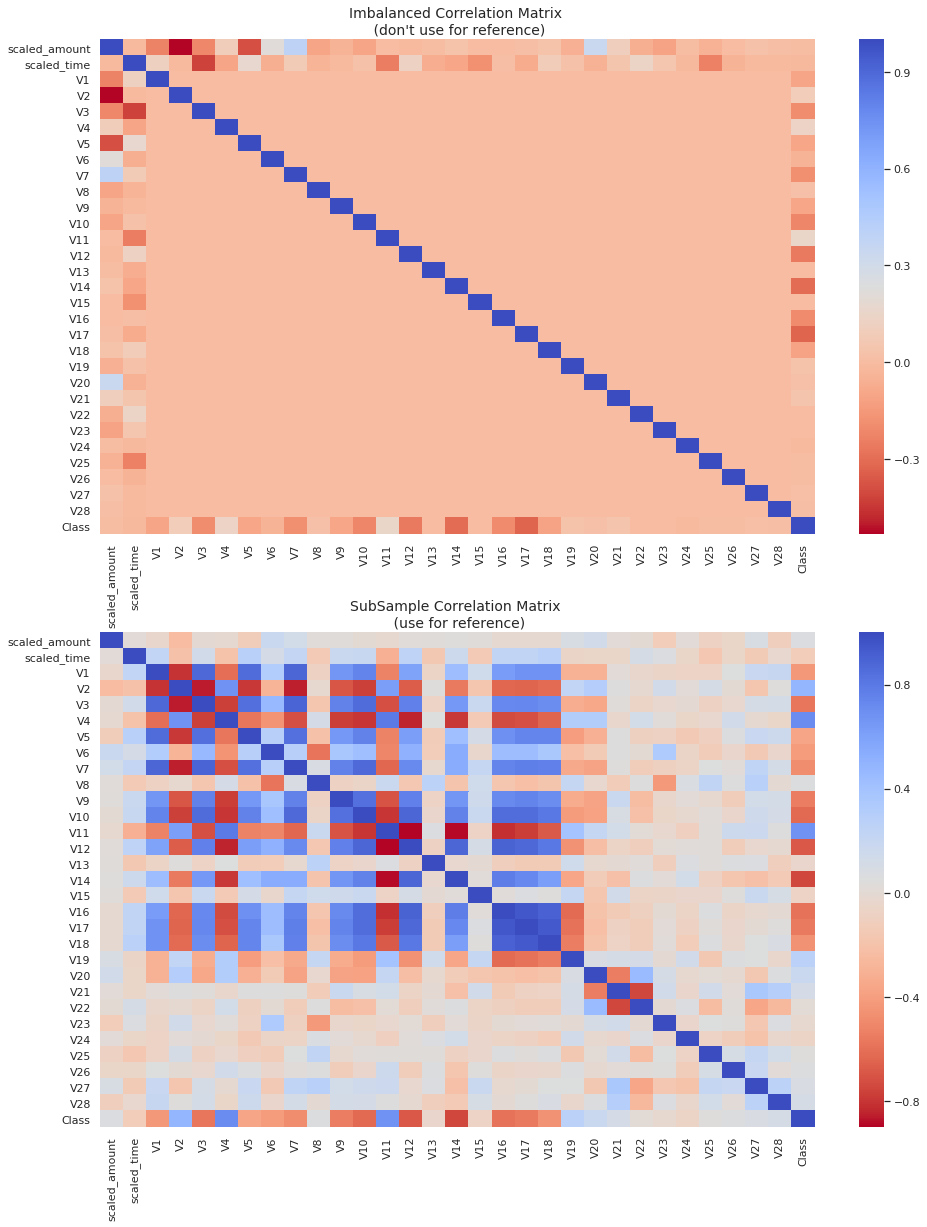

In [30]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 20))

# Entire DataFrame (to show how the correlation looks like in an imbalanced dataset)
corr = df.corr() # calculate correlation between features
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title("Imbalanced Correlation Matrix \n (don't use for reference)", fontsize=14)

# Subsampled DataFrame
sub_sample_corr = new_df.corr() # calculate correlation between features
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax2)
ax2.set_title("SubSample Correlation Matrix \n (use for reference)", fontsize=14)
plt.show()

The visual is nice, but let's see which ones are the most positively and negatively correlated in text format:

In [31]:
sol = (sub_sample_corr.where(np.triu(np.ones(sub_sample_corr.shape), k=1).astype(np.bool))
                 .stack()
                 .sort_values(ascending=False))

print(sol[0:9])
print(sol[-9:-1])

V16  V17    0.952315
V17  V18    0.938775
V16  V18    0.909471
V12  V16    0.903240
V3   V7     0.889423
V1   V7     0.885387
V12  V14    0.883681
V10  V12    0.883532
V1   V3     0.879135
dtype: float64
V4   V10   -0.799500
V10  V11   -0.800297
V1   V2    -0.804982
V11  V16   -0.812117
V4   V12   -0.841453
V2   V7    -0.850942
     V3    -0.857886
V11  V14   -0.891551
dtype: float64


We can see from the output which variables are positively and negatively correlated strongly. Some of these are highly correlated.

Now, if we look at the bottom of the second figure, we can see the correlation between the features and the class (fraud or not fraud). We are able to make out the following:

V2, V4, V11, and V19 are all very positively correlated with the class. This means that the higher the value for one of these features, the more likely it will be a fraud transaction.

V10, V12, V14, and V16 are all very negatively correlated with the class. This means that the lower the value for one of these features, the more likely it will be a fraud transaction.

Let's use boxplots to get a better understanding of the distribution of these 8 features in fraudulent and non fraudulent transactions:

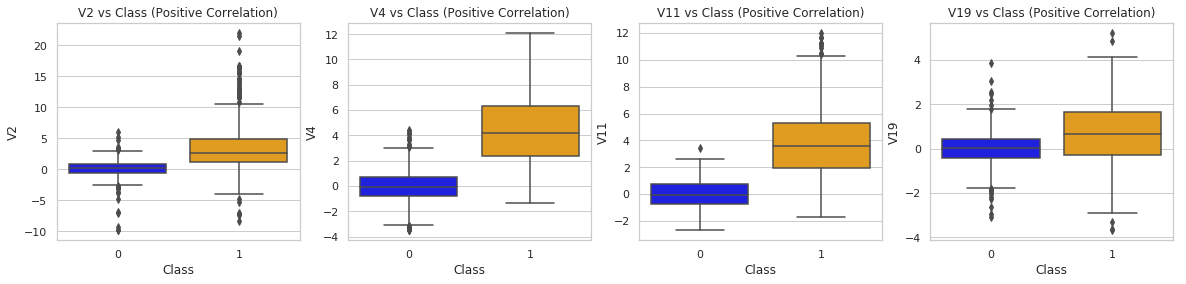

In [34]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))

# Creating the boxplot
sns.boxplot(x="Class", y="V2", data=new_df, palette=colors, ax=axes[0])
axes[0].set_title('V2 vs Class (Positive Correlation)')

sns.boxplot(x="Class", y="V4", data=new_df, palette=colors, ax=axes[1])
axes[1].set_title('V4 vs Class (Positive Correlation)')

sns.boxplot(x="Class", y="V11", data=new_df, palette=colors, ax=axes[2])
axes[2].set_title('V11 vs Class (Positive Correlation)')

sns.boxplot(x="Class", y="V19", data=new_df, palette=colors, ax=axes[3])
axes[3].set_title('V19 vs Class (Positive Correlation)')

plt.show()

We can see that the features selected here have a statistically higher value when there is a fraudulent transaction. We don't know what these features actually mean, but we (at least) have somewhat of an understanding of their correlation with the class. This can be very useful when we are further preparing our dataset for our model.

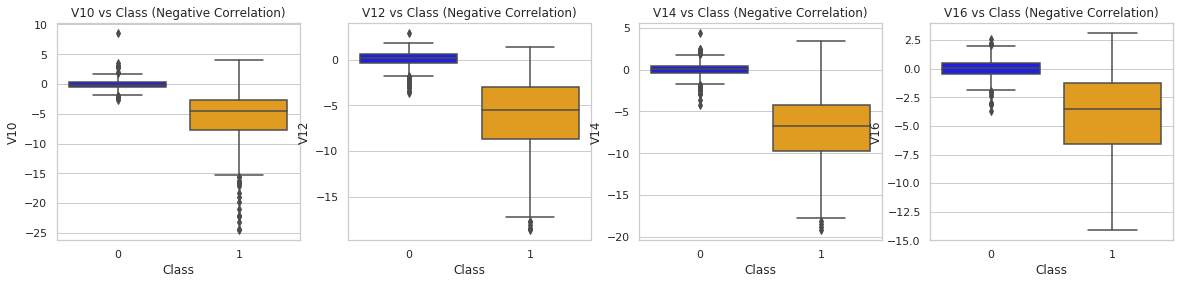

In [35]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))

# Creating the boxplot (negative correlation)
sns.boxplot(x="Class", y="V10", data=new_df, palette=colors, ax=axes[0])
axes[0].set_title('V10 vs Class (Negative Correlation)')

sns.boxplot(x="Class", y="V12", data=new_df, palette=colors, ax=axes[1])
axes[1].set_title('V12 vs Class (Negative Correlation)')

sns.boxplot(x="Class", y="V14", data=new_df, palette=colors, ax=axes[2])
axes[2].set_title('V14 vs Class (Negative Correlation)')

sns.boxplot(x="Class", y="V16", data=new_df, palette=colors, ax=axes[3])
axes[3].set_title('V16 vs Class (Negative Correlation)')

plt.show()

We can see that the features selected here have a statistically lower value (in the negative numbers) when there is a fraudulent transaction.

Figure to better understand boxplots:

![Image](https://discourse-cdn-sjc1.com/business6/uploads/analyticsvidhya/original/2X/d/d11281b44c2e440b36aaf29156b5032105d2d06b.png)

## Anomaly Detection

Now that we now which are the features with the highest correlation with our classes, we will be removing the extreme outliers from those features in order to improve the accuracy of our models.

We will do this by using the **Interquartile Range Method**. Essentially, we will create a threshold beyond the lower/upper extremes (25th and 75th percentiles), and any value that passes that threshold will be removed from our dataset.

To get our threshold for removing "extreme outliers:, we will multiply the interquartile range by a number we will judge as reasonable. Of course, there is a tradeoff here when deciding where to place the thresold. If we put it too far from the extremes, we may end up including "extreme" outliers in the dataset. If we are too close from the extremes, then we risk removing "normal" outliers.

We can always come back and play with the threshold to see how it affects our classification models. 

**Summary of the next steps**:

*   **Visualize Distributions**: We'll start by visualizing the distribution of the features we are going to use to eliminate outliers.
*   **Determiner the threshold**: We will calculate the threshold based on the multiplier we've decided on.
*   **Conditional Dropping**: We will drop any values that pass the threshold.
*   **Boxplot Representation**: We will finally visualize the boxplot to see how much it has changed now that we have removed the "extreme outliers".



## Performing Logistic Regression

In [0]:
X = df.iloc[:, :-1].dropna() # iloc selects all rows based on the index
y = df['Class'].dropna()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35)

In [18]:
# C in LR is a penalty term meant to dissentivize and regularize LR to avoid overfitting.
LR = linear_model.LogisticRegression(C=1e5)
LR.fit(X_train, y_train)
print('Score: ', LR.score(X_test, y_test))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Score:  0.9983709273182957


In [19]:
y_predicted = np.array(LR.predict(X_test))
print(y_predicted)

[0. 0. 0. ... 0. 0. 0.]


# Building the Main Model

Before we move forward, there are a few things we need to keep in mind when building our model:



*   Never test your model on the oversampled or undersampled dataset.
*   If we want to implement cross-validation, remember to oversample or undersample your training data **during** cross-validation, not before!
*   We should not be using an **accuracy score** as a metric with imbalanced datasets. If we do, we will receive high accuracy because of the imbalance and it will mislead us into thinking that we have a good model. Instead, it is much better to use either the **F1-Score, Precision/Recall Score or a Confusion Matrix**.

